In [1]:
%matplotlib inline
%run utils.ipynb

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import arviz as az
import seaborn as sns

import kinesis as kn
import gapipes as gp

plt.style.use(mystyledict)

In [4]:
out_full = pd.read_csv("../data/hyades_full.csv")
df = out_full.loc[out_full['in_dr2'] == True].copy()
b0 = np.median(df.g.icrs.cartesian.xyz.value, axis=1)
with np.printoptions(formatter=dict(float=lambda x:'{:7.3f}'.format(x))):
    print(f'b0 = {b0} pc')

def add_cartesian_xv(df):
    df['x'], df['y'], df['z'] = df.g.icrs.cartesian.xyz.value
    df['vx'], df['vy'], df['vz'] = df.g.icrs.velocity.d_xyz.value
    df['gx'], df['gy'], df['gz'] = df.g.galactic.cartesian.xyz.value
    df['gvx'], df['gvy'], df['gvz'] = df.g.galactic.velocity.d_xyz.value
add_cartesian_xv(out_full)
add_cartesian_xv(df)

b0 = [ 17.268  41.643  13.606] pc


In [5]:
fn = '../report/hyades-dr2/fit.pickle'

In [6]:
fit = kn.load_stanfit(fn)
azfit = az.from_pystan(fit)

v = azfit
for ck, cv in kn.decompose_T(v.posterior['T_param']).items():
    v.posterior[ck]=cv
sigv_samples, Omega_samples = v.posterior['sigv'],  v.posterior['Omega']
Sigma_samples = np.einsum('cni,cnij,cnj->cnij', sigv_samples, Omega_samples, sigv_samples)
v.posterior['Sigma'] = ('chain','draw','Simga_dim_0','Sigma_dim_1'), Sigma_samples
v.posterior['Sigma_gal'] = ('chain','draw','Simga_dim_0','Sigma_dim_1'), kn.rotate_T_to_galactic(Sigma_samples)
v.posterior['T_param_gal'] = ('chain','draw','dim0','dim1'), kn.rotate_T_to_galactic(v.posterior['T_param'])
for ck, cv in kn.decompose_T(v.posterior['T_param_gal']).items():
    v.posterior[ck+'_gal']  = cv

## Table of summary statistics

In [7]:
from IPython.display import display, HTML
var_names = list(azfit.posterior.data_vars.keys())
for c in ['probmem','a_model','rv_model']:
    if c in var_names:
        var_names.remove(c)
with pd.option_context("display.max_rows", 100):
    display(HTML(az.summary(azfit, var_names).to_html()))

/data/vault/soh/projects/opensource/arviz/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
v0[0],-6.073,0.028,-6.125,-6.021,0.001,0.001,1362.0,1362.0,1363.0,2296.0,1.00
v0[1],45.683,0.052,45.585,45.778,0.001,0.001,1298.0,1298.0,1303.0,2452.0,1.00
v0[2],5.543,0.024,5.495,5.586,0.001,0.000,1400.0,1400.0,1410.0,2094.0,1.00
sigv[0],0.434,0.047,0.343,0.518,0.002,0.001,945.0,945.0,952.0,1276.0,1.01
sigv[1],0.536,0.066,0.404,0.652,0.002,0.001,1235.0,1235.0,1291.0,1353.0,1.00
sigv[2],0.365,0.039,0.287,0.434,0.001,0.001,1197.0,1197.0,1195.0,1653.0,1.00
"Omega[0,0]",1.000,0.000,1.000,1.000,0.000,0.000,4000.0,4000.0,4000.0,4000.0,NaN
"Omega[0,1]",0.280,0.179,-0.058,0.615,0.006,0.004,912.0,912.0,935.0,1378.0,1.01
"Omega[0,2]",0.080,0.143,-0.186,0.337,0.004,0.003,1023.0,1023.0,1016.0,1476.0,1.00
"Omega[1,0]",0.280,0.179,-0.058,0.615,0.006,0.004,912.0,912.0,935.0,1378.0,1.01


## Mean velocity

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


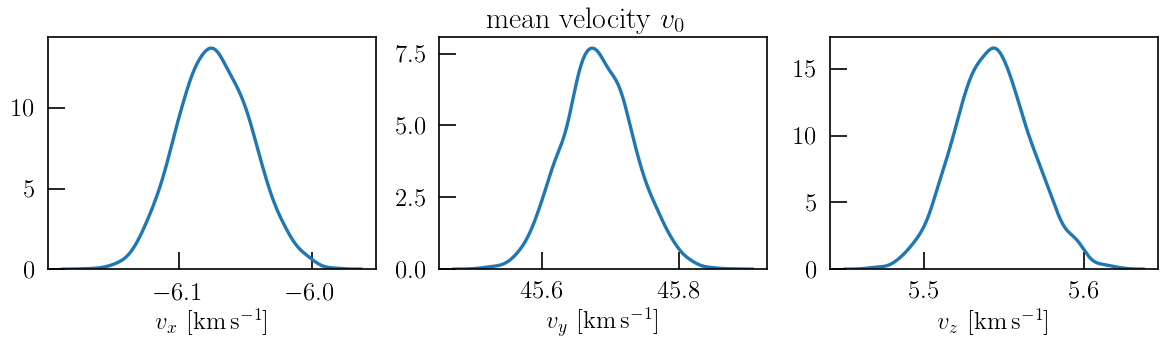

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
v = azfit
for i, cax in enumerate(ax):
    sns.kdeplot(
        v.posterior["v0"].stack(samples=["chain", "draw"])[i],
        ax=cax,
        legend=False,
    )
ax[0].set_xlabel("$v_x$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[1].set_xlabel("$v_y$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax[2].set_xlabel("$v_z$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
fig.suptitle('mean velocity $v_0$');
fig.tight_layout()

## Velocity dispersion

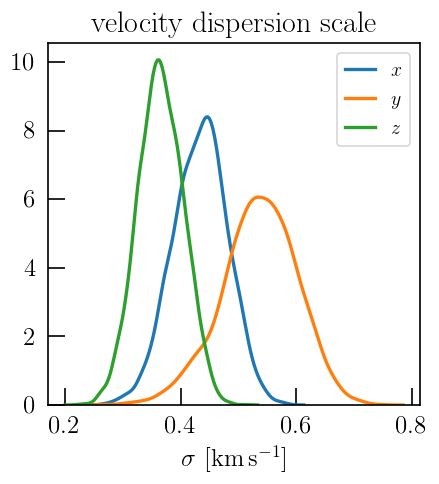

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
v = azfit
cax = ax
for i, axis in zip(range(3), ['x','y','z']):
    sns.kdeplot(
        v.posterior["sigv"].stack(samples=["chain", "draw"])[i],
        ax=cax,
        label='${}$'.format(axis),
        legend=False,
    )
ax.set_xlabel("$\sigma$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
ax.legend();
ax.set_title('velocity dispersion scale');

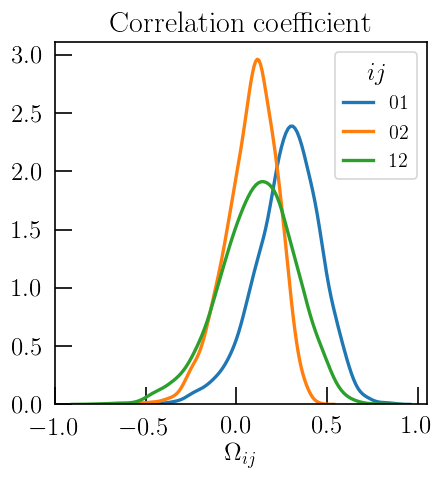

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
Omega_offdiag = (
    azfit.posterior["Omega"].stack(i=["chain", "draw"]).values[[0, 0, 1], [1, 2, 2], :]
)
for val, label in zip(Omega_offdiag, ["01", "02", "12"]):
    sns.kdeplot(val, label=label, ax=ax)
ax.set_xlabel('$\Omega_{ij}$')
ax.set_title('Correlation coefficient');
ax.set_xticks([-1,-0.5,0,0.5,1]);
ax.legend(title='$ij$');

In [17]:
sigv1d = np.sqrt((fit['sigv']**2).sum(axis=1)/3)

In [21]:
np.mean(sigv1d)

0.4525864012690205

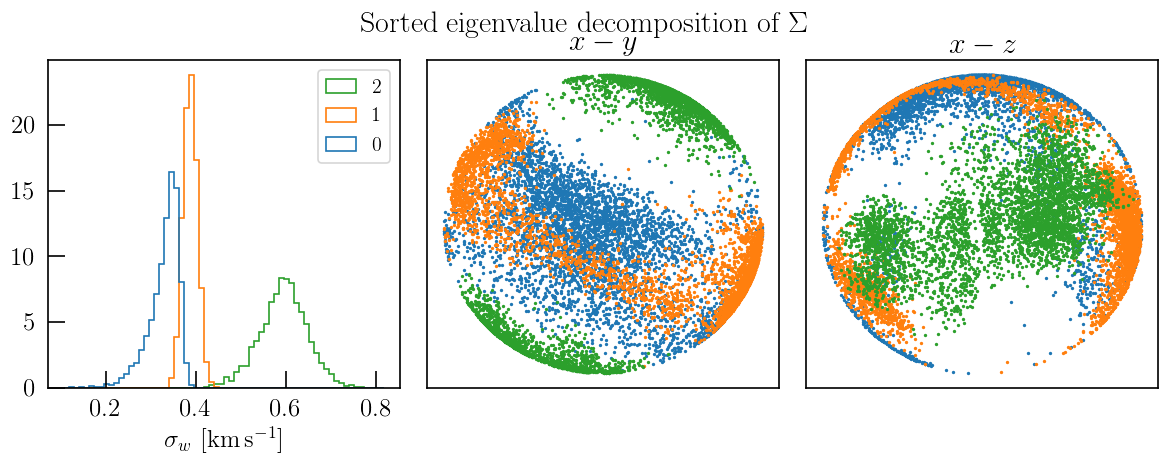

In [19]:
eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma'].stack(samples=['chain','draw']).T)

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(np.sqrt(eig.w), density=True, bins=64, histtype='step', label=['0','1','2']);
# ax[0].hist(np.sqrt(eig.w.sum(axis=1)/3), density=True, bins=64)
# ax[0].hist(sigv1d, density=True, bins=64)
for i in range(3):
    ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
    ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout()

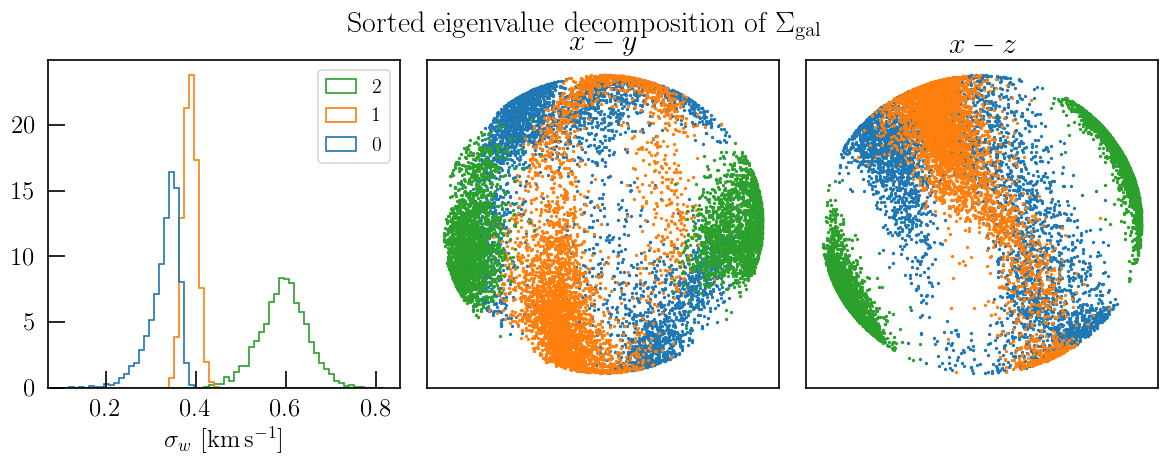

In [12]:
eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma_gal'].stack(samples=['chain','draw']).T)

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(np.sqrt(eig.w), density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
    ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma_\mathrm{gal}$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout()

eigval mean = [  +0.329   +0.388   +0.594]
eigval std  = [  +0.035   +0.016   +0.053]


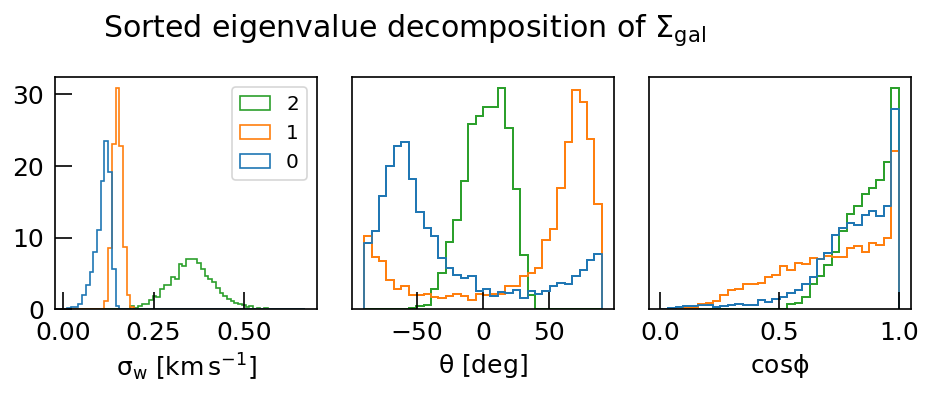

In [51]:
def cleanyticks(cax):
    cax.set_yticks([])

eig = kn.EigenvalueDecomposition(
    azfit.posterior['Sigma_gal'].stack(samples=['chain','draw']).T)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(np.sqrt(eig.w).mean(axis=0), precision=3))
    print('eigval std  = {}'.format(np.sqrt(eig.w).std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(eig.w, density=True, bins=64, histtype="step", label=["0", "1", "2"])
for i in range(3):
    ax[1].hist(
        eig.theta, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
    ax[2].hist(
        eig.cosphi, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
fig.suptitle("Sorted eigenvalue decomposition of $\Sigma_\mathrm{gal}$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r"$\theta$ [deg]")
ax[2].set_xlabel("$\cos\phi$")

ax[0].legend()
fig.tight_layout(rect=[0.15, 0.15, 0.95, 0.9])

## Linear velocity field

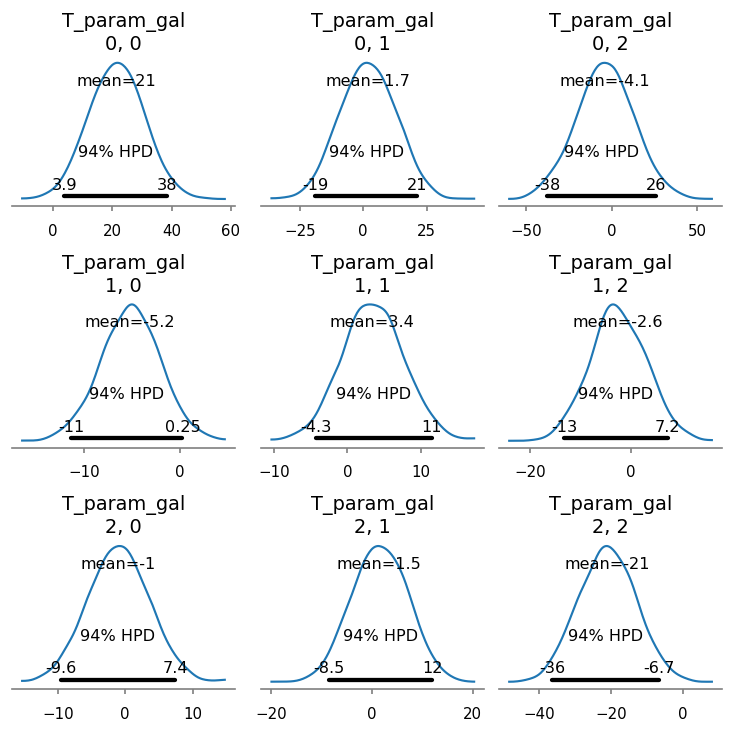

In [59]:
az.plot_posterior(azfit, 'T_param_gal', figsize=(6,6), textsize=9);

In [63]:
probmem_mean = fit["probmem"].mean(axis=0)
members = probmem_mean > 0.5
grp = cdf.groupby(members)
d = grp.get_group(True)

In [80]:
cc = coord.ICRS(*(b0*u.pc), *(fit['v0'].mean(axis=0)*u.km/u.s),
                representation_type='cartesian', differential_type='cartesian')
ccg = cc.transform_to(coord.Galactic)
v0_g = ccg.velocity.d_xyz.value
b0_g = ccg.cartesian.xyz.value

(-2, 2)

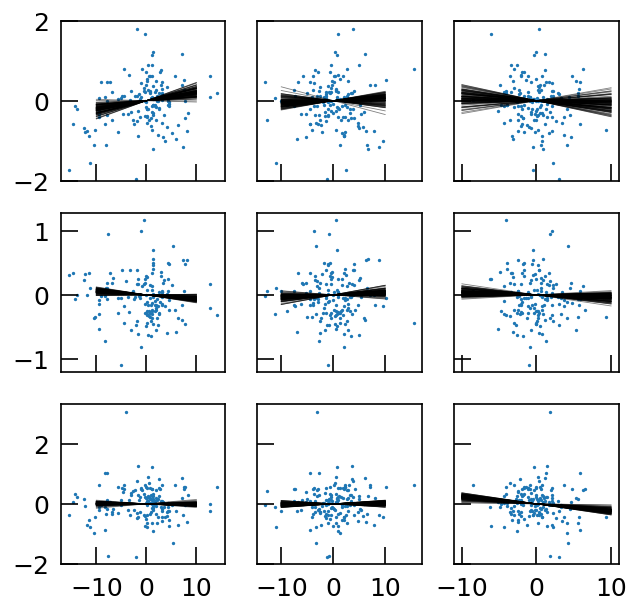

In [92]:
fig, ax = plt.subplots(3,3, figsize=(6,6), sharex='col', sharey='row')
i_random = np.random.randint(0, 4000, 100)
# ax[0,0].scatter(d['gx'],d['gvx'], s=1)
# ax[0,1].scatter(d['gy'],d['gvx'], s=1)
# ax[0,2].scatter(d['gz'],d['gvx'], s=1)
T = azfit.posterior['T_param_gal'].stack(i=['chain','draw']).values
xs=np.linspace(-10,10,101)
v0=fit['v0'].mean(axis=0)

for i_row, ylabel in zip([0,1,2], ['gvx','gvy','gvz']):
    for i_col, xlabel in zip([0,1,2], ['gx','gy','gz']):
        ax[i_row,i_col].scatter(d[xlabel]-b0_g[i_col],d[ylabel]-v0_g[i_row],s=1)
        for i in i_random:
            ax[i_row,i_col].plot(xs, T[i_row,i_col,i]/1e3*(xs), lw=.5, color='k',alpha=.5)
ax[0,0].set_ylim(-2,2)

### Rotation

omega =  +10.642 +-    5.034


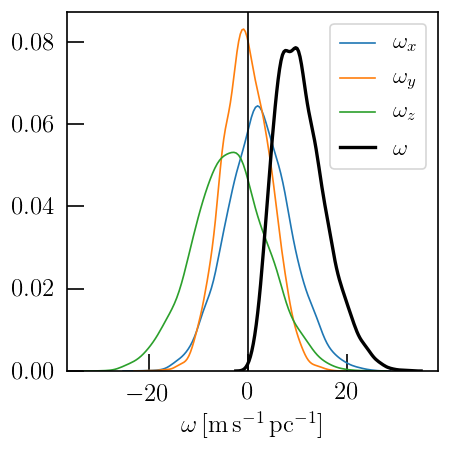

In [19]:
wT = azfit.posterior.stack(i=['chain','draw'])
fig, ax = plt.subplots(figsize=(4,4))
sns.distplot(wT["omegax"], hist=False, kde_kws={'lw':1}, label=r'$\omega_x$')
sns.distplot(wT["omegay"], hist=False, kde_kws={'lw':1}, label=r'$\omega_y$')
sns.distplot(wT["omegaz"], hist=False, kde_kws={'lw':1}, label=r'$\omega_z$')
omega = np.sqrt(wT["omegax"] ** 2 + wT["omegay"] ** 2 + wT["omegaz"] ** 2)
print(f"omega = {np.mean(omega.values):+8.3f} +- {np.std(omega.values):8.3f}")
sns.distplot(omega, hist=False, color='k', label=r'$\omega$')
ax.axvline(0, c='k', lw=1)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\omega\,[\rm m\,\rm s^{-1}\,\rm pc^{-1}]$');
fig.tight_layout()

### Shear

eigval mean = [ -23.689   +2.422  +24.944]
eigval std  = [  +8.468   +4.238   +8.607]


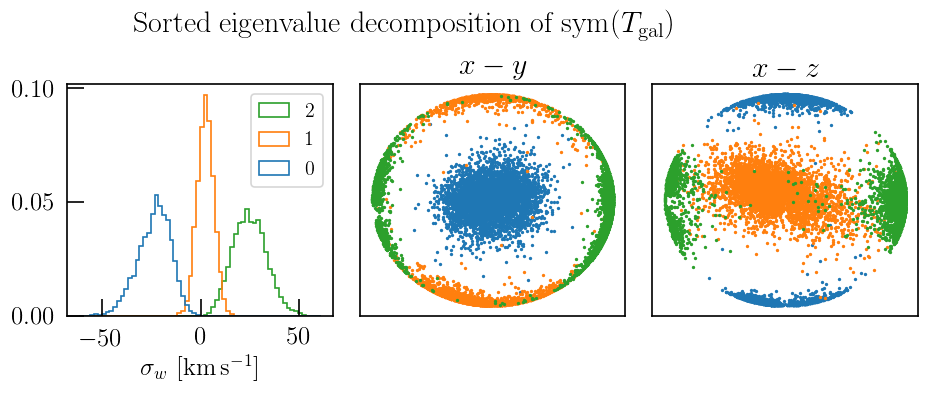

In [13]:
T_galactic = kn.rotate_T_to_galactic(fit["T_param"])
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.


eig = kn.EigenvalueDecomposition(T_sym)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(eig.w.mean(axis=0), precision=3))
    print('eigval std  = {}'.format(eig.w.std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(eig.w, density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].scatter(eig.v[:,0,i], eig.v[:,1,i],s=1);
    ax[2].scatter(eig.v[:,0,i], eig.v[:,2,i],s=1);
fig.suptitle(r"Sorted eigenvalue decomposition of $\mathrm{sym}(T_{\rm gal})$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
def cleanticks(cax):
    cax.set_xticks([])
    cax.set_yticks([])
cleanticks(ax[1])
cleanticks(ax[2])
ax[1].set_title('$x-y$')
ax[2].set_title('$x-z$');
ax[0].legend()
fig.tight_layout(rect=[0.15,0.15,0.95,0.95])

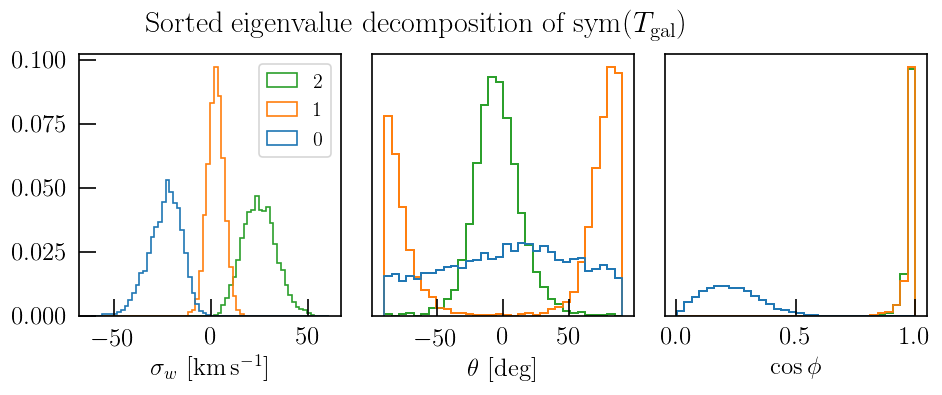

In [16]:
def cleanyticks(cax):
    cax.set_yticks([])

T_galactic = kn.rotate_T_to_galactic(fit["T_param"])
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.0
eig = kn.EigenvalueDecomposition(T_sym)


fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].hist(eig.w, density=True, bins=64, histtype="step", label=["0", "1", "2"])
for i in range(3):
    ax[1].hist(
        eig.theta, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
    ax[2].hist(
        eig.cosphi, histtype="step", density=True, bins=32, color=["C0", "C1", "C2"]
    )
fig.suptitle(r"Sorted eigenvalue decomposition of $\mathrm{sym}(T_{\rm gal})$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r"$\theta$ [deg]")
ax[2].set_xlabel("$\cos\phi$")

ax[0].legend()
fig.tight_layout(rect=[0.15, 0.15, 0.95, 0.95])

eigval mean = [ -23.689   +2.422  +24.944]
eigval std  = [  +8.468   +4.238   +8.607]


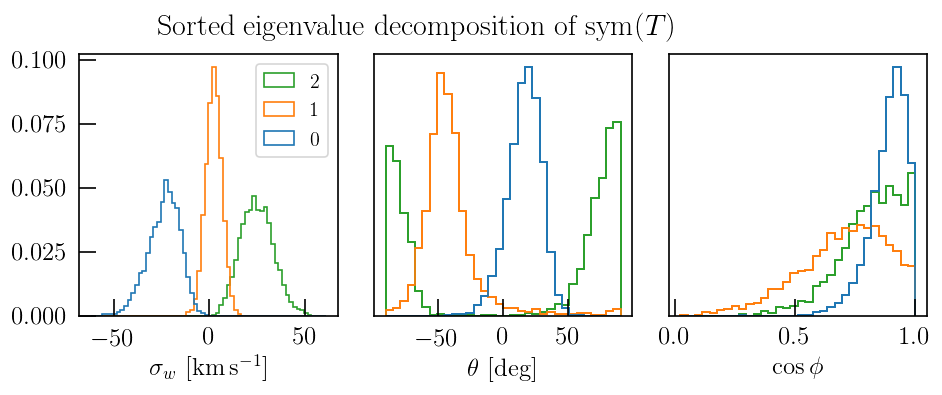

In [18]:
def cleanyticks(cax):
    cax.set_yticks([])

T_galactic = fit["T_param"]
T_sym = (T_galactic + np.transpose(T_galactic, (0, 2, 1))) / 2.
eig = kn.EigenvalueDecomposition(T_sym)
with np.printoptions(formatter=dict(float=lambda x:'{:+8.3f}'.format(x))):
    print('eigval mean = {}'.format(eig.w.mean(axis=0), precision=3))
    print('eigval std  = {}'.format(eig.w.std(axis=0), precision=3))

fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(eig.w, density=True, bins=64, histtype='step', label=['0','1','2']);
for i in range(3):
    ax[1].hist(eig.theta, histtype='step', density=True, bins=32, color=['C0','C1','C2'])
    ax[2].hist(eig.cosphi, histtype='step', density=True, bins=32, color=['C0','C1','C2'])
fig.suptitle("Sorted eigenvalue decomposition of $\mathrm{sym}(T)$")
ax[0].set_xlabel("$\sigma_w$ [$\mathrm{km}\,\mathrm{s}^{-1}$]")
cleanyticks(ax[1])
cleanyticks(ax[2])
ax[1].set_xlabel(r'$\theta$ [deg]')
ax[2].set_xlabel('$\cos\phi$')

ax[0].legend()
fig.tight_layout(rect=[0.15,0.15,0.95,0.95])

## Membership

In [14]:
cdf = pd.DataFrame({'ra':fit.data['ra'], 'dec':fit.data['dec']})
cdf['parallax'], cdf['pmra'], cdf['pmdec'] = fit.data['a'].T
cdf.loc[fit.data['irv'], 'radial_velocity'] = fit.data['rv']
add_cartesian_xv(cdf)

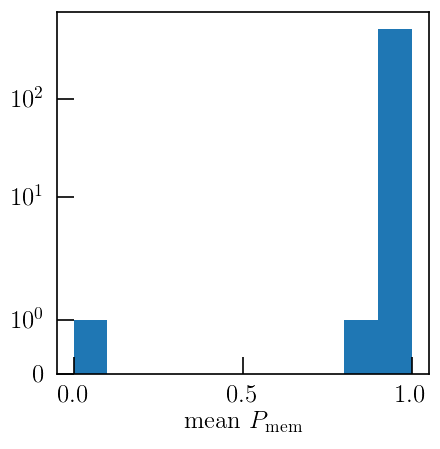

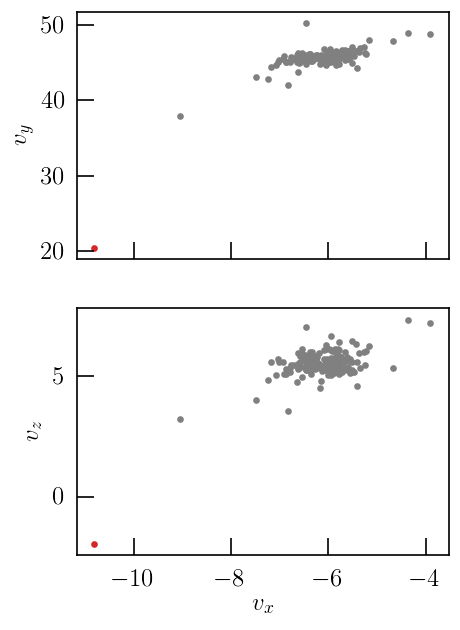

In [15]:
from matplotlib.gridspec import GridSpec

probmem_mean = fit["probmem"].mean(axis=0)
members = probmem_mean > 0.5
grp = cdf.groupby(members)

fig, ax = plt.subplots()
ax.hist(probmem_mean)
ax.set_yscale("symlog")
ax.set_xlabel(r"mean $P_{\rm mem}$")

with plt.rc_context(rc={"axes.prop_cycle": plt.cycler(color=["tab:red", "gray"])}):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=True)
    # gs = GridSpec(4, 1)
    # ax1 = fig.add_subplot(gs[:3])
    # ax2 = fig.add_subplot(gs[3], sharex=ax1)
    for label, g in grp:
        ax1.scatter(g["vx"], g["vy"], s=9)
        ax2.scatter(g["vx"], g["vz"], s=9)
    ax2.set_xlabel(r'$v_x$')
    ax2.set_ylabel(r'$v_z$')
    ax1.set_ylabel(r'$v_y$')

In [24]:
cc = coord.ICRS(*(b0*u.pc), *(fit['v0'].mean(axis=0)*u.km/u.s),
                representation_type='cartesian', differential_type='cartesian')
ccg = cc.transform_to(coord.Galactic)
vx,vy,vz = ccg.velocity.d_xyz.value

In [47]:
# fig, ax = plt.subplots()
# g = grp.get_group(True)    # remove outliers
# ax.scatter(g["gx"]-ccg.cartesian.x.value, g["gvx"]-vx, s=9)
# ax.scatter(g["gy"]-ccg.cartesian.y.value, g["gvy"]-vy, s=9)
#     ax.scatter(g["gx"], g["gvz"]-vz, s=9)